Первый шаг - импорт необходимых библиотек. Открываем предварительно загруженный файл .xlsx. В лишний пустой столбец будем записывать месяц рассматриваемой покупки - переименуем его и заполним пустыми строками для избежания проблем с совместимостью форматов. Также определим формат столбца receiving_date для работы с датами.


In [19]:
import pandas as pd
import numpy as np

dataset = pd.read_excel('/content/drive/MyDrive/Тестовое задание/data.xlsx')
dataset.rename(columns={'Unnamed: 5': 'month'}, inplace=True)
dataset.month = ''
dataset.replace(['-'], np.nan, inplace=True)
dataset.receiving_date.astype("datetime64[ns]")
dataset

,client_id,sum,status,sale,new/current,month,document,receiving_date
0,NaN,NaN,Май 2021,NaN,NaN,,NaN,NaT
1,6.0,11693.7,ВНУТРЕННИЙ,NaN,NaN,,NaN,NaT
2,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,,оригинал,2021-07-26
3,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,,оригинал,2021-06-08
4,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,,оригинал,2021-06-08
...,...,...,...,...,...,...,...,...
725,285.0,4328.7,ОПЛАЧЕНО,Васильев,текущая,,оригинал,2021-11-15
726,360.0,3096.2,ОПЛАЧЕНО,Васильев,новая,,НЕТ,NaT
727,360.0,3096.2,ПРОСРОЧЕНО,Васильев,новая,,НЕТ,NaT
728,373.0,4403.7,ОПЛАЧЕНО,Михайлов,новая,,оригинал,2021-11-08


Месяцы отделены друг от друга строками с пустыми значениями всех атрбиутов, кроме Status. Определим индексы этих строк путем итерирования по itertuples датафрейма и проверкой на NaN значения client_id. В результате получены два списка - названия месяцев и индексы строк, содержащих эти названия. По полученным данным заполним столбец 'month' датафрейма.

In [20]:
list_months, list_index = [], []
for x in dataset.itertuples():
  if pd.isnull(x.client_id):
    list_months.append(x.status)
    list_index.append(x[0])
list_index.append(dataset.shape[0])

now = list_index[0]
for index, month in zip(list_index[1:], list_months):
  dataset.loc[now: index, 'month'] = month
  now = index
  now += 1

Удалим из датафрейма строки, содержащие только названия месяца за ненадобностью.

In [21]:
dataset.drop(list_index[:-1], axis=0, inplace=True)

dataset.groupby('month')['client_id'].count()

month
Август 2021      114
Июль 2021        110
Июнь 2021        128
Май 2021         128
Октябрь 2021     135
Сентябрь 2021    109
Name: client_id, dtype: int64

Предобработка данных успешно завершена, количество строк с данными осталось прежним.

# Ответы на вопросы:

1) Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.

In [22]:
dataset.query("month == 'Июль 2021' and not status == 'ПРОСРОЧЕНО'")['sum'].sum()

859896.4699999997

Ответ: 859896.47

2) Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.

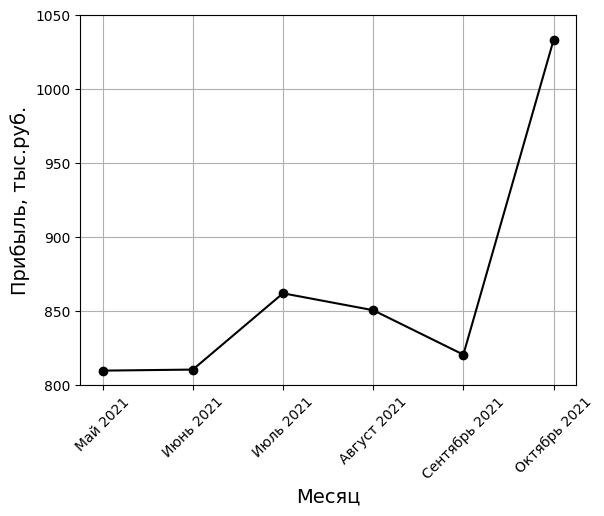

,sum
month,
Май 2021,809.57219
Июнь 2021,810.26611
Июль 2021,861.87417
Август 2021,850.43579
Сентябрь 2021,820.38378
Октябрь 2021,1033.14839


In [23]:
import matplotlib.pyplot as plt

order_months = ['Май 2021', 'Июнь 2021', 'Июль 2021', 'Август 2021', 'Сентябрь 2021', 'Октябрь 2021']

plot_data = dataset.groupby('month').agg({'sum': 'sum'}).apply(lambda x: x / 1000, axis=1).reindex(order_months, axis=0)

plt.plot(plot_data, c='black', marker='o')
plt.xlabel("Месяц", fontsize=14)
plt.ylabel("Прибыль, тыс.руб.", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(800, 1050)
plt.grid()
plt.show()
plot_data

В соответствии с графиком, по сравнению с маем, прибыль в июне практически не изменилась. В июле прибыль выросла примерно на 5%, после чего на протяжении двух месяцев прибыль снижалась примерно до значений мая-июня. В октябре прибыль выросла примерно на 20% по сравнению с сентябрем.

3) Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?

In [24]:
dataset.query("month == 'Сентябрь 2021'").groupby('sale').agg({'sum': 'sum'}).sort_values('sum', ascending=False)

,sum
sale,
Смирнов,221525.70
Петрова,149344.46
Андреев,133652.50
Иванов,94770.60
Кузнецова,72228.40
Филимонова,59514.47
Васильев,49895.45
Соколов,35183.50
Михайлов,4268.70


Ответ: Смирнов

4) Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

In [25]:
dataset.query("month == 'Октябрь 2021'").groupby('new/current').client_id.count().sort_values(ascending=False)

new/current
текущая    99
новая      36
Name: client_id, dtype: int64

Ответ: текущая

5) Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [26]:
dataset.query("month == 'Май 2021' and receiving_date.dt.month == 6").client_id.count()

77

Ответ: 77

# Выполнение задания:

Для начала определим функцию, рассчитывающую сумму бонуса в зависимости от выполнения условий.

In [27]:
def calc_bonus(x):
  if x['new/current'] == 'новая' and x['status'] == 'ОПЛАЧЕНО':
    return 0.07 * x['sum']
  elif x['new/current'] == 'текущая' and not x['status'] == 'ПРОСРОЧЕНА':
    if x['sum'] > 10000:
      return 0.05 * x['sum']
    else:
      return 0.03 * x['sum']
  return 0

Добавим в датафрейм новый столбец, рассчитывающий значения при помощи определенной ранее функции.

In [28]:
dataset['bonus'] = dataset.apply(calc_bonus, axis=1)

К остаткам на 01.07.2021 относятся выплаты с тех сделок, которые были заключены до этой даты (т.е. в Мае и Июне) и для которых оригинал подписанного договора пришел позже этой даты. Следовательно, остаток для каждого из менеджеров можно определить следующим образом:

In [29]:
counting_date = pd.to_datetime('01.07.2021.')

dataset.query("receiving_date > @counting_date and month in ['Май 2021', 'Июнь 2021']").groupby('sale').agg({'bonus': 'sum'})

,bonus
sale,
Андреев,8752.9944
Васильев,1376.2800
Иванов,8495.2910
Кузнецова,7101.6217
Петрова,17799.5494
Селиванов,5651.0120
Смирнов,12176.9550
Соколов,269.2110
Филимонова,3259.4629
